In [1]:
import os
#import cv2
import numpy as np
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from tensorflow.keras import models
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix ,plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = (train_images - 127.5) / 127.5
test_images = test_images.astype('float32')/255.


train_images.shape

(60000, 28, 28)

In [3]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
generator = keras.Sequential(
    [
        keras.Input(shape=(100)),
        layers.Dense((7*7*128)),
        layers.Reshape((7,7,128)),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        #layers.Dropout(0.1),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        #layers.Dropout(0.1),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
        #layers.Reshape((28,28)),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       51

In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
	    layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 128)       3328      
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 56, 56, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 112, 112, 128)     409728    
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 112, 112, 128)   

In [6]:

# connect them
GANS = keras.Sequential()
# add generator
GANS.add(generator)
# add the discriminator
GANS.add(discriminator)
# compile model
opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

GANS.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
discriminator.trainable = False

# Generate MVN and Images from it

In [7]:
def genMVD(batchSize):
    MVN = np.random.randn(1, 100)
    for i in range(batchSize-1):
        MVN = np.concatenate((MVN,np.random.randn(1,100)),axis=0)
    return MVN

In [8]:
def makeBatch(batch):
    fakeBatch = genMVD(batch)
    #print(fakeBatch.shape)
    fakeGenImg = generator.predict(fakeBatch)
    randReals = np.random.randint(train_images.shape[0], size=batch)
    realImg =  train_images[randReals]

    #print(realImg.shape,fakeGenImg.shape)
    realImg = realImg.reshape(batch, 28, 28,1)
    trainingBatch_images = np.concatenate((realImg,fakeGenImg),axis=0)
    #print(trainingBatch_images.shape)
    trainingBatch_labels =  np.append(np.ones(batch),np.zeros(batch))
    relist = np.random.permutation(2*batch)
    trainingBatch_images =  trainingBatch_images[relist,:,:]
    trainingBatch_labels = trainingBatch_labels[relist]
    return trainingBatch_images,trainingBatch_labels

# Train Disciminator



In [9]:
d_hist = []
g_hist = []
for j in tqdm(range(100)):
    btch = 16
    if not j % 10:
        print("Round: ",j)
    discriminator.trainable = True
    #for i in tqdm(range(10),desc= "Disc"):
    for i in range(10):
        batchsize = btch
        trainBImgs, trainBLabs = makeBatch(batchsize)
        history = discriminator.fit(trainBImgs, trainBLabs,
                                    batch_size = batchsize,
                                    epochs = batchsize,
                                    verbose=0)
        d_hist.append(list(history.history['loss']))
    discriminator.trainable = False
    #for i in tqdm(range(10),desc = "Gen"):
    for i in range(10):
        batchsize = btch
        trainBImgs= genMVD(batchsize)
        history = GANS.fit(trainBImgs, np.ones(batchsize),
                                    batch_size = batchsize,
                                    epochs = batchsize,
                                    verbose=0)
        g_hist.append(list(history.history['loss']))

g_hist = [item for sublist in g_hist for item in sublist]
d_hist = [item for sublist in d_hist for item in sublist]

  0%|          | 0/10 [00:00<?, ?it/s]

Round:  0


100%|██████████| 10/10 [06:02<00:00, 36.20s/it]


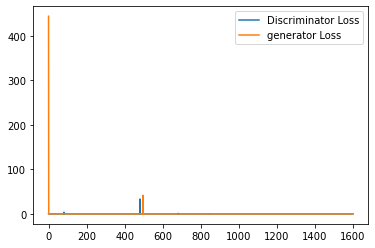

In [10]:
fig,ax = plt.subplots()
ax.plot(d_hist,label="Discriminator Loss")
ax.plot(g_hist,label="generator Loss")

plt.legend()
plt.show()

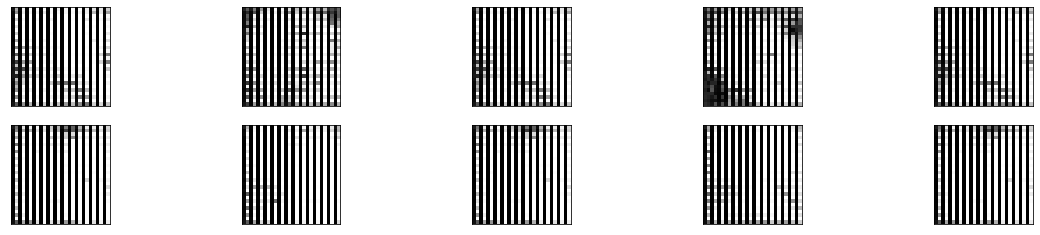

In [11]:
fakeBatch = genMVD(10)
#print(fakeBatch.shape)
pix = generator.predict(fakeBatch)
display(pix[:pix.shape[0]//2,:],pix[pix.shape[0]//2:,:])